<a href="https://colab.research.google.com/github/TheUnseenz/Final-Year-Project/blob/master/FYP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Final Year Project**\
Semi-supervised machine learning - Pseudo-labelling technique
We modify the pseudo-labelling to label using its certainty distribution instead of a binary [0,1] outcome.

FYP: MNIST dataset.

EVALUATION: | Epoch: 268 | Iteration [100/100] | Loss 0.03 | Accuracy 84.36% | Run-time 2.81
TRAINING RESULTS: | Epochs: 268 | Train Loss: 0.033 | Train Acc: 100.00% | Val. Loss: 0.030 | Val. Acc: 81.33% | Total Run-time: 70.79
Pseudo-score Statistics: Mean: 1.01418 | Median: 1.00969 | Range: 1.00039 - 1.05000


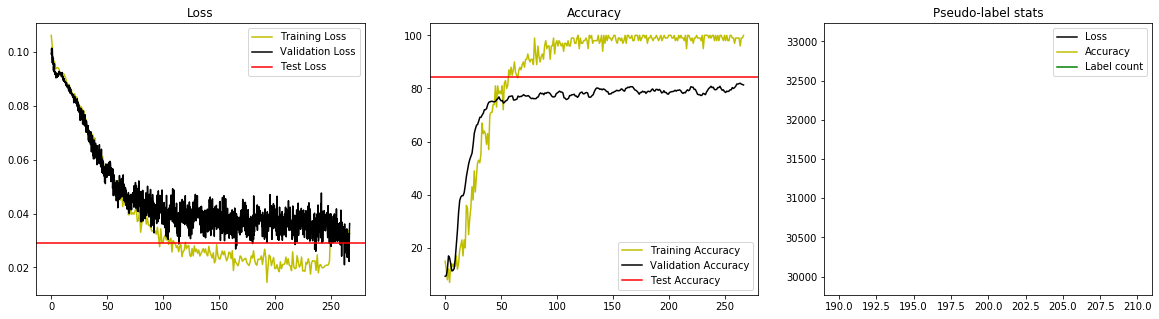

In [0]:
# FYP 
############################# SUBSAMPLED MNIST #################################
# Imports
import numpy as np
import torch
import torchvision
import torchvision.datasets as datasets
import torchvision.transforms as T
from torch import nn, optim
import torch.utils.data as data
from torch.utils.data import DataLoader as dataloader
import torch.nn.functional as F
from IPython.display import clear_output
import time
import matplotlib
import matplotlib.pyplot as plt

# from torch.autograd import Variable
# import random
def softmax(x):
    """Compute softmax values for each sets of scores in x."""
    e_x = torch.exp(x - torch.max(x))
    return e_x / e_x.sum()

# Input size = 28x28.
class LeNet(nn.Module):
    def __init__(self, channels_in):
        #Call the __init__ function of the parent nn.module class
        super(LeNet, self).__init__()
        #Define Convolution Layers
        #conv1 6 channels_inx5x5 kernals
        self.conv1 = nn.Conv2d(channels_in,6,kernel_size=3)
        #conv2 16 6x5x5 kernals
        self.conv2 =  nn.Conv2d(6,16,kernel_size=3)
        #Define MaxPooling Layers
        #https://computersciencewiki.org/index.php/Max-pooling_/_Pooling
        #Default Stride is = to kernel_size
        self.maxpool = nn.MaxPool2d(kernel_size=2)
        self.dropout1 = nn.Dropout(p=0.5)
        self.dropout2 = nn.Dropout2d(p=0.2)
        #Define Linear/Fully connected/ Dense Layers
        #Input to linear1 is the number of features from previous conv - 16x5x5
        #output of linear1 is 120
        self.linear1 =  nn.Linear(16*5*5,120)
        #output of linear2 is 84
        self.linear2 =  nn.Linear(120,84)
        #output of linear3 is 10
        self.linear3 =  nn.Linear(84,10)
            
    def forward(self, x):
        #Pass input through conv layers
        out1 = F.relu(self.conv1(x))#Conv then F.relu()  
        #out1 shape is BatchSize-6-28-28
        out1 = self.dropout2(out1)
        out1 = self.maxpool(out1)#maxpool  
        #out1 shape is BatchSize-6-14-14

        out2 = F.relu(self.conv2(out1))#Conv then F.relu() 
        #out2 shape is BatchSize-16-10-10
        out2 = self.dropout2(out2)
        out2 = self.maxpool(out2)#maxpool 
        #out2 shape is BatchSize-16-5-5
        #Flatten out2 to shape BatchSize-16x5x5
        out2 = out2.view(out2.shape[0],-1) 
        
        out3 = F.relu(self.linear1(out2))#linear then F.relu()  
        #out3 shape is BatchSize-120
        out3 = self.dropout1(out3)
        out4 = F.relu(self.linear2(out3))#linear then F.relu()  
        #out4 shape is BatchSize-84
        out4 = self.dropout1(out4)
        out5 = self.linear3(out4)#linear to output 
        #out5 shape is BatchSize-10
        return out5  
     
      
def calculate_accuracy(fx, y):
    # For MSELoss
    if (onehot == True):
      preds = torch.argmax(fx, dim=1)
      correct = torch.argmax(y, dim=1)
      acc = (torch.sum(torch.eq(preds,correct))).float()/preds.shape[0]
    else: 
      # For Cross-Entropy Loss
      preds = fx.max(1, keepdim=True)[1]
      correct = preds.eq(y.view_as(preds)).sum()
      acc = correct.float()/preds.shape[0]
    return acc

#This function should perform a single training epoch using our training data
def train(net, device, loader, optimizer, pseudo_loader, Loss_fun, loss_logger, acc_logger):
    
    #initialise counters
    epoch_loss = 0
    epoch_acc = 0
    
    #Set Network in train mode
    net.train()
    start_time = time.time()
    for i, (x, y) in enumerate(loader):
        #Convert to 1-hot encoding. Disable if using CrossEntropyLoss
        if (onehot == True):
          y = torch.eye(10)[y]
          
        #Add pseudo-labels
        if epoch>minEpoch:
          for (x1,y1) in pseudo_loader:
            x = torch.cat([x, x1], 0)
            y = torch.cat([y, y1], 0)
#             x = x1 # To test label quality
#             y = y1 # To test label quality
            break        
        
        #load images and labels to device
        x = x.to(device) # x is the image
        y = y.to(device) # y is the corresponding label
                
        #Forward pass of image through network and get output
        fx = net((x))
        
        #Calculate loss using loss function
        loss = Loss_fun(fx,y)
        
        #calculate the accuracy
        acc = calculate_accuracy(fx[0:batch_size],y[0:batch_size])

        #Zero Gradents
        optimizer.zero_grad()
        
        #Backpropagate Gradents
        loss.backward()
        
        #Do a single optimization step
        optimizer.step()
        
        #create the cumulative sum of the loss and acc
        epoch_loss += loss.item()
        epoch_acc += acc.item()
        
        #log the loss for plotting
        loss_logger.append(loss.item())
        
        #Clear the output of the running cell
        if (debug == False):
          clear_output(True)
          end_time = time.time()
          print("TRAINING: | Epoch %d | Iteration [%d/%d] | Loss %.2f | Run-time %.2f" %(epoch+1, i+1, len(loader) ,loss.item(),end_time-start_time))
    acc_logger.append(100*epoch_acc/(i+1))
    #Clear memory to avoid memory overload
    del [x, y, fx]        
    
    #return the avaerage loss and acc from the epoch as well as the logger array       
    return epoch_loss / len(loader), epoch_acc / len(loader), loss_logger, acc_logger
  
#This function should perform a single evaluation epoch and will be passed our validation or evaluation/test data
#it WILL NOT be used to train out model
def evaluate(net, device, loader, Loss_fun, loss_logger = None, acc_logger = None):
    
    epoch_loss = 0
    epoch_acc = 0
    
    #Set network in evaluation mode
    #Layers like Dropout will be disabled
    #Layers like Batchnorm will stop calculating running mean and standard deviation
    #and use current stored values
    net.eval()
    start_time = time.time()
    with torch.no_grad():
        for i, (x, y) in enumerate(loader):
            #Convert to 1-hot encoding. Disable if using CrossEntropyLoss
            if (onehot == True):
              y = torch.eye(10)[y]
            
            #load images and labels to device
            x = x.to(device)
            y = y.to(device)
            
            #Forward pass of image through network
            fx = net((x))
            
            #Calculate loss using loss function
            loss = Loss_fun(fx,y)
            
            #calculate the accuracy
            acc = calculate_accuracy(fx,y)
            
            #log the cumulative sum of the loss and acc
            epoch_loss += loss.item()
            epoch_acc += acc.item()
            
            #log the loss for plotting if we passed a logger to the function
            if not (loss_logger is None):
                loss_logger.append(loss.item())
                
            if (debug == False):
              clear_output(True)
              end_time = time.time()
              print("EVALUATION: | Epoch: %d | Iteration [%d/%d] | Loss %.2f | Accuracy %.2f%% | Run-time %.2f" %(epoch+1,i+1 ,len(loader), loss.item(), 100*(epoch_acc/ (i+1)),end_time-start_time))
        if not (acc_logger is None):
            acc_logger.append(100*epoch_acc/(i+1))
    #Clear memory to avoid memory overload
    del [x, y, fx]        

    #return the average loss and acc from the epoch as well as the logger array       
    return epoch_loss / len(loader), epoch_acc / len(loader), loss_logger, acc_logger


def pseudolabel(net, device, loader, Loss_fun, pseudo_x, pseudo_y, pseudo_score, loss_logger = None, acc_logger = None):    
    epoch_loss = 0
    epoch_acc = 0    
    #Set network in evaluation mode
    #Layers like Dropout will be disabled
    #Layers like Batchnorm will stop calculating running mean and standard deviation
    #and use current stored values
    start_time = time.time()
    net.eval()
    with torch.no_grad():
      try:
        for i, (x) in enumerate(loader):
            #load images and labels to device
            x = x.to(device)
            
            #Forward pass of image through network
            fx = net((x))
            y = (softmax(fx)-(torch.min(softmax(fx),1, keepdim=True)[0]))/((torch.max(softmax(fx),1, keepdim=True)[0])-(torch.min(softmax(fx),1, keepdim=True)[0])) # Normalizes yfit so its labels range [0,1]
            y = y**2 # Labels which are further apart are more certain, but we want to have some uncertainty in the correct answer.
            # Thresholding: Remove all labels deemed too uncertain to be helpful            
            yscore = torch.sum(y,dim=1)
            certainLabels = yscore<1.5
#####################################################################################################                        
#             y = torch.floor(y) # This would be the normal pseudo-labelling. Test the differences. Otherwise, use below:           
            # 'Normalize' y to sum to 1, range is now 0>y<1 instead of [0,1]
            y1 = y/torch.sum(y,1).view(y.shape[0],-1) 
            y1 = y1[certainLabels,:]
            x1 = x[certainLabels,:,:,:]
            y2 = torch.floor(y[~certainLabels,:])
            x2 = torch.floor(x[~certainLabels,:])
            
            if (certainLabels.sum()>0 and certainLabels.sum()!=x.shape[0]):
              y = torch.cat([y1,y2])        
              x = torch.cat([x1,x2])        
            elif (certainLabels.sum() == 0):
              y = y2
              x = x2              

#           # Discard uncertain labels   
#             y = y1
#             x = x1

#####################################################################################################            
            if y.shape == torch.Size([10]): # Necessary for case 0x10, all other nx10 works.
                y = torch.unsqueeze(y,0)
                x = torch.unsqueeze(x,0)

            if (len(pseudo_y)==0): # To get the dimensions of pseudo_x,y initialised right
                pseudo_x = x.cpu()
                pseudo_y = y.cpu()                
            else:
                pseudo_x = torch.cat([pseudo_x,x.cpu()],dim=0)
                pseudo_y = torch.cat([pseudo_y,y.cpu()],dim=0)

            yscore = yscore[certainLabels]
            pseudo_score = torch.cat([pseudo_score,yscore.cpu()])
            if len(yscore)>1: # so that it can be printed
                 yscore = torch.min(yscore)
            if debug == False and i%100 == 99:
              clear_output(True)          
              end_time = time.time()
              print("PSEUDO-LABELLING: | Epoch %d | Iteration [%d/%d] | Total label count: %d | Run-time: %.2f" %(epoch+1,i+1 ,len(loader),len(pseudo_score),end_time-start_time))
              if (len(pseudo_score)>0):
                print("Pseudo-score Statistics: Mean: %.5f | Median: %.5f | Range: %.5f - %.5f" %(torch.mean(pseudo_score),torch.median(pseudo_score),torch.min(pseudo_score),torch.max(pseudo_score)))
      except KeyboardInterrupt:
        pass
    #Clear memory to avoid memory overload
    del [x, y, fx]        
    
    #return the average loss and acc from the epoch as well as the logger array       
    return epoch_loss / len(loader), epoch_acc / len(loader), pseudo_x, pseudo_y, pseudo_score, loss_logger, acc_logger
  

  
GPU_indx = 0
device = torch.device(GPU_indx if torch.cuda.is_available() else 'cpu')
toImage = T.ToPILImage()
transform = T.Compose([
#     T.RandomRotation(15),
    T.ToTensor(),
    T.Normalize((0.5,), (0.5,))
])
# Load MNIST data
trainset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)  # Length: 60 000
testset = datasets.MNIST(root='./data', train=False, download=True, transform=transform)  # Length: 10 000
# mnist_trainset[i] = Dataset i, mnist_trainset[i][0] = image for data set i, mnist_trainset[i][1] = label for data set i
# mnist_trainset. -> hit tab to see classes/functions under it

###########################
#Create train and validation set by splitting training data with 90/10% traning/validation split
train_data = trainset
test_data = testset
num_targets = 10
batch_size = 100
validation_split = 0.99
n_train_examples = int(len(trainset)*validation_split)
n_valid_examples = len(trainset) - n_train_examples
train_data, valid_data = torch.utils.data.random_split(trainset, [n_train_examples, n_valid_examples])
# Create labelled vs unlabelled data. 
labelSamples = 10 # Number of samples for each label/number
labelledData = []
unlabelledData = []
for i in range(num_targets):
  labelledData = np.concatenate((labelledData,np.where(trainset.targets == i)[0][0:labelSamples]))
  unlabelledData = np.concatenate((unlabelledData,np.where(trainset.targets == i)[0][labelSamples::]))  
train_labelled_debug = trainset.data[labelledData]
train_labels = trainset.targets[labelledData]
train_unlabelled_debug = trainset.data[unlabelledData]
# Surely there's a better way to do this transformation of image data?
train_labelled = torch.zeros(train_labelled_debug.shape[0],1,28,28)
for j in range(train_labelled_debug.shape[0]):
  train_labelled[j] = (transform(toImage(train_labelled_debug[j])))
train_labelled = data.TensorDataset(train_labelled,train_labels)

train_unlabelled = torch.zeros(train_unlabelled_debug.shape[0],1,28,28)
for k in range(train_unlabelled_debug.shape[0]):
  train_unlabelled[k] = (transform(toImage(train_unlabelled_debug[k])))

train_loader_labelled =  dataloader(train_labelled,shuffle=True,batch_size = batch_size)
train_loader_unlabelled = dataloader(train_unlabelled,shuffle=True,batch_size = batch_size)
train_loader = dataloader(train_data,shuffle=True,batch_size = batch_size)
valid_loader = dataloader(valid_data,shuffle=True,batch_size = batch_size)
test_loader = dataloader(testset,shuffle=True,batch_size = batch_size)
#create a dataloader itterable object
dataiter = iter(train_loader)
#sample from the itterable object
images, labels = dataiter.next()
# trainx[np.where(trainy == i)[0][0:label_samples]] finds first (label_samples) examples of i
##################################################
# Model parameters
net = LeNet(images.shape[1]).to(device)
lr = 0.002
weight_decay = lr/10
optimizer = optim.Adam(net.parameters(), lr=lr, weight_decay = weight_decay)
Loss_fun = nn.MSELoss()
# Loss_fun = nn.BCEWithLogitsLoss() 
onehot = True;
debug = False;
pretrain_epochs = 20
epochs = 1500
minEpoch = 200
resetEpoch = 50

##################################################
# Begin
pretrain_loss_logger = []
pretrain_acc_logger = []
training_loss_logger = []
training_acc_logger = []
validation_loss_logger = []
validation_acc_logger = []
pseudo_x = []
pseudo_y = []
pseudo_score = torch.Tensor()
pseudo_loader = []
pseudo_loss_logger = []
pseudo_acc_logger = []
pseudo_count = []
start_time = time.time()
    
try:    
  for epoch in range(epochs):
    # Dataloader object automatically shuffles datasets with shuffle=True
    #Train on the training set, pass training dataloader etc
    train_loss, train_acc, training_loss_logger, training_acc_logger = train(net,device,train_loader_labelled,optimizer,pseudo_loader,Loss_fun,training_loss_logger,training_acc_logger)

    #Evaluate the validation set, pass validation dataloader etc
    valid_loss, valid_acc, validation_loss_logger, validation_acc_logger = evaluate(net,device,valid_loader,Loss_fun,validation_loss_logger,validation_acc_logger)
    
    #Pseudo-label with our unlabelled set
    if (epoch>=minEpoch and epoch%resetEpoch==(resetEpoch-1) and epoch<(epochs-1)):
        pseudo_x = []
        pseudo_y = []
        pseudo_score = torch.Tensor()
        pseudo_loss, pseudo_acc, pseudo_x, pseudo_y, pseudo_score, pseudo_loss_logger, pseudo_acc_logger = pseudolabel(net,device,train_loader_unlabelled,Loss_fun,pseudo_x,pseudo_y,pseudo_score,pseudo_loss_logger,pseudo_acc_logger)
        pseudo_loader = dataloader(data.TensorDataset(pseudo_x,pseudo_y),shuffle=True,batch_size = batch_size*2)
        if (len(pseudo_score)>0):
          pseudo_count.append(len(pseudo_score))
        else:
          pseudo_count.append(0)
        torch.cuda.empty_cache()
    
  
except KeyboardInterrupt: # Upon pressing 'Stop', exit the loop and run the testing.
    pass

#Test results:
test_loss, test_acc, _, _ = evaluate(net,device,test_loader,Loss_fun)
end_time = time.time()
print(f'TRAINING RESULTS: | Epochs: {epoch+1:02} | Train Loss: {train_loss:.3f} | Train Acc: {train_acc*100:05.2f}% | Val. Loss: {valid_loss:.3f} | Val. Acc: {valid_acc*100:05.2f}% | Total Run-time: {(end_time-start_time):.2f}')
if (len(pseudo_score)>0):
  print("Pseudo-score Statistics: Mean: %.5f | Median: %.5f | Range: %.5f - %.5f" %(torch.mean(pseudo_score),torch.median(pseudo_score),torch.min(pseudo_score),torch.max(pseudo_score)))

#Plot our loss and accuracy logs
if (debug == False):
  plt.figure(figsize = (20,5))
  plt.subplot(1,3,1)
  train_x = np.linspace(0, epoch, len(training_loss_logger))
  plt.plot(train_x, training_loss_logger, c = "y")
  valid_x = np.linspace(0, epoch, len(validation_loss_logger))
  plt.plot(valid_x, validation_loss_logger, c = "k")
  plt.axhline(y=test_loss, color='r', linestyle='-')
  plt.title("Loss")
  plt.legend(["Training Loss", "Validation Loss", "Test Loss"])

  plt.subplot(1,3,2)
  train_acc_x = np.linspace(0, epoch, len(training_acc_logger))
  plt.plot(train_acc_x, training_acc_logger, c = "y")
  valid_acc_x = np.linspace(0, epoch, len(validation_acc_logger))
  plt.plot(valid_acc_x, validation_acc_logger, c = "k")
  plt.axhline(y=test_acc*100, color='r', linestyle='-')
  plt.title("Accuracy")
  plt.legend(["Training Accuracy", "Validation Accuracy", "Test Accuracy"])
  
  plt.subplot(1,3,3)
  pseudo_loss_x = np.linspace(minEpoch,epoch,len(pseudo_loss_logger))
  plt.plot(pseudo_loss_x,pseudo_loss_logger, c = "k")
  pseudo_acc_x = np.linspace(minEpoch, epoch, len(pseudo_acc_logger))
  plt.plot(pseudo_acc_x,pseudo_acc_logger,c = "y")
  pseudo_count_x = np.linspace(minEpoch, epoch, len(pseudo_count))
  plt.plot(pseudo_count_x,pseudo_count,c = "g")
  plt.title("Pseudo-label stats")
  plt.legend(["Loss","Accuracy","Label count"])



FYP: Fashion-MNIST dataset.

Debug: The net we use

In [0]:
class LeNet(nn.Module):
    def __init__(self, channels_in):
        #Call the __init__ function of the parent nn.module class
        super(LeNet, self).__init__()
        model = []
        model.append(nn.Conv2d(channels_in,6,kernel_size=5))
        model.append(nn.ReLU())
#         model.append(nn.Dropout2d(p=0.2))
        model.append(nn.MaxPool2d(kernel_size=2))
        model.append(nn.Conv2d(6,16,kernel_size=5))
        model.append(nn.ReLU())
#         model.append(nn.Dropout2d(p=0.2))
        model.append(nn.MaxPool2d(kernel_size=2))
        model.append(Flatten())
        model.append(nn.Linear(16*5*5,120))
        model.append(nn.ReLU())
#         model.append(nn.Dropout(p=0.5))
        model.append(nn.Linear(120,84))
        model.append(nn.ReLU())
#         model.append(nn.Dropout(p=0.5))
        model.append(nn.Linear(84,10))
#         #Define Convolution Layers
#         #conv1 6 channels_inx5x5 kernals
#         self.conv1 = nn.Conv2d(channels_in,6,kernel_size=3)
#         #conv2 16 6x5x5 kernals
#         self.conv2 =  nn.Conv2d(6,16,kernel_size=3)
#         #Define MaxPooling Layers
#         #https://computersciencewiki.org/index.php/Max-pooling_/_Pooling
#         #Default Stride is = to kernel_size
#         self.maxpool = nn.MaxPool2d(kernel_size=2)
#         self.dropout1 = nn.Dropout(p=0.5)
#         self.dropout2 = nn.Dropout2d(p=0.2)
#         #Define Linear/Fully connected/ Dense Layers
#         #Input to linear1 is the number of features from previous conv - 16x5x5
#         #output of linear1 is 120
#         self.linear1 =  nn.Linear(16*5*5,120)
#         #output of linear2 is 84
#         self.linear2 =  nn.Linear(120,84)
#         #output of linear3 is 10
#         self.linear3 =  nn.Linear(84,10)
        self.model = nn.Sequential(*model)
    def forward(self, x):
        #Pass input through model
#         out1 = F.relu(self.conv1(x))#Conv then F.relu()  
#         #out1 shape is BatchSize-6-28-28
#         out1 = self.dropout2(out1)
#         out1 = self.maxpool(out1)#maxpool  
#         #out1 shape is BatchSize-6-14-14

#         out2 = F.relu(self.conv2(out1))#Conv then F.relu() 
#         #out2 shape is BatchSize-16-10-10
#         out2 = self.dropout2(out2)
#         out2 = self.maxpool(out2)#maxpool 
#         #out2 shape is BatchSize-16-5-5
#         #Flatten out2 to shape BatchSize-16x5x5
#         out2 = out2.view(out2.shape[0],-1) 
        
#         out3 = F.relu(self.linear1(out2))#linear then F.relu()  
#         #out3 shape is BatchSize-120
#         out3 = self.dropout1(out3)
#         out4 = F.relu(self.linear2(out3))#linear then F.relu()  
#         #out4 shape is BatchSize-84
#         out4 = self.dropout1(out4)
#         out5 = self.linear3(out4)#linear to output 
#         #out5 shape is BatchSize-10
        return self.model(x) 

class Flatten(torch.nn.Module):
    def forward(self, x):
        batch_size = x.shape[0]
        return x.view(batch_size, -1) 
      
net = LeNet(1).to(device)
net

LeNet(
  (model): Sequential(
    (0): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Flatten()
    (7): Linear(in_features=400, out_features=120, bias=True)
    (8): ReLU()
    (9): Linear(in_features=120, out_features=84, bias=True)
    (10): ReLU()
    (11): Linear(in_features=84, out_features=10, bias=True)
  )
)

Debug: View our pseudo-label certainty

In [0]:
  # x is input image of size 28x28, y is prediction vector of size 10
# Pass input x through the neural network
y = net(x)
# Softmax our output: Normalizes it to pdf that sums to 1
y = softmax(y)
# Normalizes it to have a min/max of [0,1]
y = (y-min(y))/(max(y)-min(y))
# Square the value of our function to drive uncertain outputs towards 0.
# Note that the min/max is still [0,1]
y = y**2 
# Normalize it to sum to 1.
y = y/sum(y)
# In contrast, the normal method for pseudo-labelling would be:
# y = floor(y)


# With this, the larger the sum of y, the more uncertain its prediction is.
yscore = sum(y)
certainLabels = yscore<ScoreThreshold

EVALUATION: | Epoch: 100 | Iteration [100/100] | Loss 0.02 | Accuracy 83.32% | Run-time 3.25
TRAINING RESULTS: | Epochs: 100 | Train Loss: 0.038 | Train Acc: 77.95% | Val. Loss: 0.026 | Val. Acc: 84.67% | Total Run-time: 2208.03


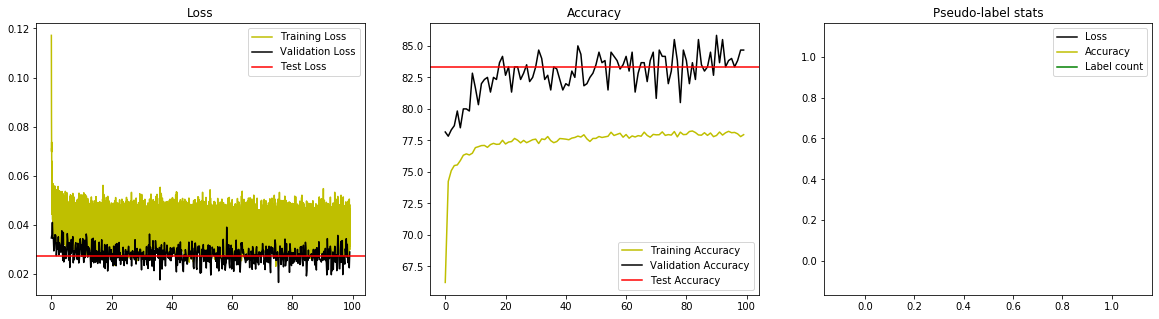

In [0]:
# FYP 
############################# SUBSAMPLED MNIST #################################
# Imports
import numpy as np
import torch
import torchvision
import torchvision.datasets as datasets
import torchvision.transforms as T
import torch.utils.data as data
import matplotlib
import matplotlib.pyplot as plt
import random
from torch import nn, optim
from torch.autograd import Variable
from torch.utils.data import DataLoader as dataloader
import torch.nn.functional as F
from IPython.display import clear_output
import time

def softmax(x):
    """Compute softmax values for each sets of scores in x."""
    e_x = torch.exp(x - torch.max(x))
    return e_x / e_x.sum()

# Input size = 28x28.
class LeNet(nn.Module):
    def __init__(self, channels_in):
        #Call the __init__ function of the parent nn.module class
        super(LeNet, self).__init__()
        #Define Convolution Layers
        #conv1 6 channels_inx5x5 kernals
        self.conv1 = nn.Conv2d(channels_in,6,kernel_size=3)
        #conv2 16 6x5x5 kernals
        self.conv2 =  nn.Conv2d(6,16,kernel_size=3)
        #Define MaxPooling Layers
        #https://computersciencewiki.org/index.php/Max-pooling_/_Pooling
        #Default Stride is = to kernel_size
        self.maxpool = nn.MaxPool2d(kernel_size=2)
        self.dropout1 = nn.Dropout(p=0.5)
        self.dropout2 = nn.Dropout2d(p=0.2)
        #Define Linear/Fully connected/ Dense Layers
        #Input to linear1 is the number of features from previous conv - 16x5x5
        #output of linear1 is 120
        self.linear1 =  nn.Linear(16*5*5,120)
        #output of linear2 is 84
        self.linear2 =  nn.Linear(120,84)
        #output of linear3 is 10
        self.linear3 =  nn.Linear(84,10)
            
    def forward(self, x):
        #Pass input through conv layers
        out1 = F.relu(self.conv1(x))#Conv then F.relu()  
        #out1 shape is BatchSize-6-28-28
        out1 = self.dropout2(out1)
        out1 = self.maxpool(out1)#maxpool  
        #out1 shape is BatchSize-6-14-14

        out2 = F.relu(self.conv2(out1))#Conv then F.relu() 
        #out2 shape is BatchSize-16-10-10
        out2 = self.dropout2(out2)
        out2 = self.maxpool(out2)#maxpool 
        #out2 shape is BatchSize-16-5-5
        #Flatten out2 to shape BatchSize-16x5x5
        out2 = out2.view(out2.shape[0],-1) 
        
        out3 = F.relu(self.linear1(out2))#linear then F.relu()  
        #out3 shape is BatchSize-120
        out3 = self.dropout1(out3)
        out4 = F.relu(self.linear2(out3))#linear then F.relu()  
        #out4 shape is BatchSize-84
        out4 = self.dropout1(out4)
        out5 = self.linear3(out4)#linear to output 
        #out5 shape is BatchSize-10
        return out5  
     
      
def calculate_accuracy(fx, y):
    # For MSELoss
    if (onehot == True):
      preds = torch.argmax(fx, dim=1)
      correct = torch.argmax(y, dim=1)
      acc = (torch.sum(torch.eq(preds,correct))).float()/preds.shape[0]
    else: 
      # For Cross-Entropy Loss
      preds = fx.max(1, keepdim=True)[1]
      correct = preds.eq(y.view_as(preds)).sum()
      acc = correct.float()/preds.shape[0]
    return acc

#This function should perform a single training epoch using our training data
def train(net, device, loader, optimizer, pseudo_loader, Loss_fun, loss_logger, acc_logger):
    
    #initialise counters
    epoch_loss = 0
    epoch_acc = 0
    
    #Set Network in train mode
    net.train()
    start_time = time.time()
    for i, (x, y) in enumerate(loader):
        #Convert to 1-hot encoding. Disable if using CrossEntropyLoss
        if (onehot == True):
          y = torch.eye(10)[y]
          
        #Add pseudo-labels
        if epoch>minEpoch:
          for (x1,y1) in pseudo_loader:
            x = torch.cat([x, x1], 0)
            y = torch.cat([y, y1], 0)
#             x = x1 # To test label quality
#             y = y1 # To test label quality
            break        
        
        #load images and labels to device
        x = x.to(device) # x is the image
        y = y.to(device) # y is the corresponding label
                
        #Forward pass of image through network and get output
        fx = net((x))
        
        #Calculate loss using loss function
        loss = Loss_fun(fx,y)
        
        #calculate the accuracy
        acc = calculate_accuracy(fx[0:batch_size],y[0:batch_size])

        #Zero Gradents
        optimizer.zero_grad()
        
        #Backpropagate Gradents
        loss.backward()
        
        #Do a single optimization step
        optimizer.step()
        
        #create the cumulative sum of the loss and acc
        epoch_loss += loss.item()
        epoch_acc += acc.item()
        
        #log the loss for plotting
        loss_logger.append(loss.item())
        
        #Clear the output of the running cell
        if (debug == False):
          clear_output(True)
          end_time = time.time()
          print("TRAINING: | Epoch %d | Iteration [%d/%d] | Loss %.2f | Run-time %.2f" %(epoch+1, i+1, len(loader) ,loss.item(),end_time-start_time))
    acc_logger.append(100*epoch_acc/(i+1))
    #Clear memory to avoid memory overload
    del [x, y, fx]        
    
    #return the avaerage loss and acc from the epoch as well as the logger array       
    return epoch_loss / len(loader), epoch_acc / len(loader), loss_logger, acc_logger
  
#This function should perform a single evaluation epoch and will be passed our validation or evaluation/test data
#it WILL NOT be used to train out model
def evaluate(net, device, loader, Loss_fun, loss_logger = None, acc_logger = None):
    
    epoch_loss = 0
    epoch_acc = 0
    
    #Set network in evaluation mode
    #Layers like Dropout will be disabled
    #Layers like Batchnorm will stop calculating running mean and standard deviation
    #and use current stored values
    net.eval()
    start_time = time.time()
    with torch.no_grad():
        for i, (x, y) in enumerate(loader):
            #Convert to 1-hot encoding. Disable if using CrossEntropyLoss
            if (onehot == True):
              y = torch.eye(10)[y]
            
            #load images and labels to device
            x = x.to(device)
            y = y.to(device)
            
            #Forward pass of image through network
            fx = net((x))
            
            #Calculate loss using loss function
            loss = Loss_fun(fx,y)
            
            #calculate the accuracy
            acc = calculate_accuracy(fx,y)
            
            #log the cumulative sum of the loss and acc
            epoch_loss += loss.item()
            epoch_acc += acc.item()
            
            #log the loss for plotting if we passed a logger to the function
            if not (loss_logger is None):
                loss_logger.append(loss.item())
                
            if (debug == False):
              clear_output(True)
              end_time = time.time()
              print("EVALUATION: | Epoch: %d | Iteration [%d/%d] | Loss %.2f | Accuracy %.2f%% | Run-time %.2f" %(epoch+1,i+1 ,len(loader), loss.item(), 100*(epoch_acc/ (i+1)),end_time-start_time))
        if not (acc_logger is None):
            acc_logger.append(100*epoch_acc/(i+1))
    #Clear memory to avoid memory overload
    del [x, y, fx]        

    #return the average loss and acc from the epoch as well as the logger array       
    return epoch_loss / len(loader), epoch_acc / len(loader), loss_logger, acc_logger


def pseudolabel(net, device, loader, Loss_fun, pseudo_x, pseudo_y, pseudo_score, loss_logger = None, acc_logger = None):    
    epoch_loss = 0
    epoch_acc = 0    
    #Set network in evaluation mode
    #Layers like Dropout will be disabled
    #Layers like Batchnorm will stop calculating running mean and standard deviation
    #and use current stored values
    start_time = time.time()
    net.eval()
    with torch.no_grad():
      try:
        for i, (x) in enumerate(loader):
            #load images and labels to device
            x = x.to(device)
            
            #Forward pass of image through network
            fx = net((x))
            y = (softmax(fx)-(torch.min(softmax(fx),1, keepdim=True)[0]))/((torch.max(softmax(fx),1, keepdim=True)[0])-(torch.min(softmax(fx),1, keepdim=True)[0])) # Normalizes yfit so its labels range [0,1]
            y = y**2 # Labels which are further apart are more certain, but we want to have some uncertainty in the correct answer.
            # Thresholding: Remove all labels deemed too uncertain to be helpful            
            yscore = torch.sum(y,dim=1)
            certainLabels = yscore<1.5
#####################################################################################################                        
#             y = torch.floor(y) # This would be the normal pseudo-labelling. Test the differences.            
            # 'Normalize' y to sum to 1, range is now 0>y<1 instead of [0,1]
            y1 = y/torch.sum(y,1).view(y.shape[0],-1) 
            y1 = y1[certainLabels,:]
            x1 = x[certainLabels,:,:,:]
            y2 = torch.floor(y[~certainLabels,:])
            x2 = torch.floor(x[~certainLabels,:])
            
            if (certainLabels.sum()>0 and certainLabels.sum()!=x.shape[0]):
              y = torch.cat([y1,y2])        
              x = torch.cat([x1,x2])        
            elif (certainLabels.sum() == 0):
              y = y2
              x = x2              
              
            y = y1
            x = x1
#####################################################################################################            
            if y.shape == torch.Size([10]): # Necessary for case 0x10, all other nx10 works.
                y = torch.unsqueeze(y,0)
                x = torch.unsqueeze(x,0)

            if (len(pseudo_y)==0): # To get the dimensions of pseudo_x,y initialised right
                pseudo_x = x.cpu()
                pseudo_y = y.cpu()                
            else:
                pseudo_x = torch.cat([pseudo_x,x.cpu()],dim=0)
                pseudo_y = torch.cat([pseudo_y,y.cpu()],dim=0)

            yscore = yscore[certainLabels]
            pseudo_score = torch.cat([pseudo_score,yscore.cpu()])
            if len(yscore)>1: # so that it can be printed
                 yscore = torch.min(yscore)
            if debug == False and i%100==99:
              clear_output(True)          
              end_time = time.time()
              print("PSEUDO-LABELLING: | Epoch %d | Iteration [%d/%d] | Total label count: %d | Run-time: %.2f" %(epoch+1,i+1 ,len(loader),len(pseudo_score),end_time-start_time))
              if (len(pseudo_score)>0):
                print("Pseudo-score Statistics: Mean: %.5f | Median: %.5f | Range: %.5f - %.5f" %(torch.mean(pseudo_score),torch.median(pseudo_score),torch.min(pseudo_score),torch.max(pseudo_score)))
      except KeyboardInterrupt:
        pass
    #Clear memory to avoid memory overload
    del [x, y, fx]        
    
    #return the average loss and acc from the epoch as well as the logger array       
    return epoch_loss / len(loader), epoch_acc / len(loader), pseudo_x, pseudo_y, pseudo_score, loss_logger, acc_logger
  

  
GPU_indx = 0
device = torch.device(GPU_indx if torch.cuda.is_available() else 'cpu')
toImage = T.ToPILImage()
transform = T.Compose([
    T.RandomRotation(15),
    T.ToTensor(),
    T.Normalize((0.5,), (0.5,))
])
# Load MNIST data
trainset = datasets.FashionMNIST(root='./data', train=True, download=True, transform=transform)  # Length: 60 000
testset = datasets.FashionMNIST(root='./data', train=False, download=True, transform=transform)  # Length: 10 000
# mnist_trainset[i] = Dataset i, mnist_trainset[i][0] = image for data set i, mnist_trainset[i][1] = label for data set i
# mnist_trainset. -> hit tab to see classes/functions under it

###########################
#Create train and validation set by splitting training data with 90/10% traning/validation split
train_data = trainset
test_data = testset
num_targets = 10
batch_size = 100
validation_split = 0.99
n_train_examples = int(len(trainset)*validation_split)
n_valid_examples = len(trainset) - n_train_examples
train_data, valid_data = torch.utils.data.random_split(trainset, [n_train_examples, n_valid_examples])
# Create labelled vs unlabelled data. 
labelSamples = 10 # Number of samples for each label/number
labelledData = []
unlabelledData = []
for i in range(num_targets):
  labelledData = np.concatenate((labelledData,np.where(trainset.targets == i)[0][0:labelSamples]))
  unlabelledData = np.concatenate((unlabelledData,np.where(trainset.targets == i)[0][labelSamples::]))  
train_labelled_debug = trainset.data[labelledData]
train_labels = trainset.targets[labelledData]
train_unlabelled_debug = trainset.data[unlabelledData]
# Surely there's a better way to do this transformation of image data?
train_labelled = torch.zeros(train_labelled_debug.shape[0],1,28,28)
for j in range(train_labelled_debug.shape[0]):
  train_labelled[j] = (transform(toImage(train_labelled_debug[j])))
train_labelled = data.TensorDataset(train_labelled,train_labels)

train_unlabelled = torch.zeros(train_unlabelled_debug.shape[0],1,28,28)
for k in range(train_unlabelled_debug.shape[0]):
  train_unlabelled[k] = (transform(toImage(train_unlabelled_debug[k])))

train_loader_labelled =  dataloader(train_labelled,shuffle=True,batch_size = batch_size)
train_loader_unlabelled = dataloader(train_unlabelled,shuffle=True,batch_size = batch_size)
train_loader = dataloader(train_data,shuffle=True,batch_size = batch_size)
valid_loader = dataloader(valid_data,shuffle=True,batch_size = batch_size)
test_loader = dataloader(testset,shuffle=True,batch_size = batch_size)
#create a dataloader itterable object
dataiter = iter(train_loader)
#sample from the itterable object
images, labels = dataiter.next()
# trainx[np.where(trainy == i)[0][0:label_samples]] finds first (label_samples) examples of i
##################################################
# Model parameters
net = LeNet(images.shape[1]).to(device)
lr = 0.002
weight_decay = lr/10
optimizer = optim.Adam(net.parameters(), lr=lr, weight_decay = weight_decay)
Loss_fun = nn.MSELoss() 
# Loss_fun = nn.BCEWithLogitsLoss() 
onehot = True;
debug = False;
pretrain_epochs = 20
epochs = 1500
minEpoch = 200
resetEpoch = 50

##################################################
# Begin
pretrain_loss_logger = []
pretrain_acc_logger = []
training_loss_logger = []
training_acc_logger = []
validation_loss_logger = []
validation_acc_logger = []
pseudo_x = []
pseudo_y = []
pseudo_score = torch.Tensor()
pseudo_loader = []
pseudo_loss_logger = []
pseudo_acc_logger = []
pseudo_count = []
start_time = time.time()
    
try:    
  for epoch in range(epochs):
    # Dataloader object automatically shuffles datasets with shuffle=True
    #Train on the training set, pass training dataloader etc
    train_loss, train_acc, training_loss_logger, training_acc_logger = train(net,device,train_loader_labelled,optimizer,pseudo_loader,Loss_fun,training_loss_logger,training_acc_logger)

    #Evaluate the validation set, pass validation dataloader etc
    valid_loss, valid_acc, validation_loss_logger, validation_acc_logger = evaluate(net,device,valid_loader,Loss_fun,validation_loss_logger,validation_acc_logger)
    
    #Pseudo-label with our unlabelled set
    if (epoch>=minEpoch and epoch%resetEpoch==(resetEpoch-1) and epoch<(epochs-1)):
        pseudo_x = []
        pseudo_y = []
        pseudo_score = torch.Tensor()
        pseudo_loss, pseudo_acc, pseudo_x, pseudo_y, pseudo_score, pseudo_loss_logger, pseudo_acc_logger = pseudolabel(net,device,train_loader_unlabelled,Loss_fun,pseudo_x,pseudo_y,pseudo_score,pseudo_loss_logger,pseudo_acc_logger)
        pseudo_loader = dataloader(data.TensorDataset(pseudo_x,pseudo_y),shuffle=True,batch_size = batch_size*2)
        if (len(pseudo_score)>0):
          pseudo_count.append(len(pseudo_score))
        else:
          pseudo_count.append(0)
        torch.cuda.empty_cache()
    
  
except KeyboardInterrupt: # Upon pressing 'Stop', exit the loop and run the testing.
    pass

#Test results:
test_loss, test_acc, _, _ = evaluate(net,device,test_loader,Loss_fun)
end_time = time.time()
print(f'TRAINING RESULTS: | Epochs: {epoch+1:02} | Train Loss: {train_loss:.3f} | Train Acc: {train_acc*100:05.2f}% | Val. Loss: {valid_loss:.3f} | Val. Acc: {valid_acc*100:05.2f}% | Total Run-time: {(end_time-start_time):.2f}')
if (len(pseudo_score)>0):
  print("Pseudo-score Statistics: Mean: %.5f | Median: %.5f | Range: %.5f - %.5f" %(torch.mean(pseudo_score),torch.median(pseudo_score),torch.min(pseudo_score),torch.max(pseudo_score)))

#Plot our loss and accuracy logs
if (debug == False):
  plt.figure(figsize = (20,5))
  plt.subplot(1,3,1)
  train_x = np.linspace(0, epoch, len(training_loss_logger))
  plt.plot(train_x, training_loss_logger, c = "y")
  valid_x = np.linspace(0, epoch, len(validation_loss_logger))
  plt.plot(valid_x, validation_loss_logger, c = "k")
  plt.axhline(y=test_loss, color='r', linestyle='-')
  plt.title("Loss")
  plt.legend(["Training Loss", "Validation Loss", "Test Loss"])

  plt.subplot(1,3,2)
  train_acc_x = np.linspace(0, epoch, len(training_acc_logger))
  plt.plot(train_acc_x, training_acc_logger, c = "y")
  valid_acc_x = np.linspace(0, epoch, len(validation_acc_logger))
  plt.plot(valid_acc_x, validation_acc_logger, c = "k")
  plt.axhline(y=test_acc*100, color='r', linestyle='-')
  plt.title("Accuracy")
  plt.legend(["Training Accuracy", "Validation Accuracy", "Test Accuracy"])
  
  plt.subplot(1,3,3)
  pseudo_loss_x = np.linspace(minEpoch,epoch,len(pseudo_loss_logger))
  plt.plot(pseudo_loss_x,pseudo_loss_logger, c = "k")
  pseudo_acc_x = np.linspace(minEpoch, epoch, len(pseudo_acc_logger))
  plt.plot(pseudo_acc_x,pseudo_acc_logger,c = "y")
  pseudo_count_x = np.linspace(minEpoch, epoch, len(pseudo_count))
  plt.plot(pseudo_count_x,pseudo_count,c = "g")
  plt.title("Pseudo-label stats")
  plt.legend(["Loss","Accuracy","Label count"])



In [0]:
test_loss, test_acc, _, _ = evaluate(net,auto_encoder,device,test_loader,Loss_fun)
print(f'TRAINING RESULTS: | Epochs: {epoch+1:02} | Train Loss: {train_loss:.3f} | Train Acc: {train_acc*100:05.2f}% | Val. Loss: {valid_loss:.3f} | Val. Acc: {valid_acc*100:05.2f}% | Total Run-time: {end_time-start_time}')
plt.figure(figsize = (20,5))
plt.subplot(1,4,1)
train_x = np.linspace(0, epoch, len(training_loss_logger))
plt.plot(train_x, training_loss_logger, c = "y")
valid_x = np.linspace(0, epoch, len(validation_loss_logger))
plt.plot(valid_x, validation_loss_logger, c = "k")
plt.axhline(y=test_loss, color='r', linestyle='-')
plt.title("Loss")
plt.legend(["Training Loss", "Validation Loss", "Test Loss"])

plt.subplot(1,4,2)
train_acc_x = np.linspace(0, epoch, len(training_acc_logger))
plt.plot(train_acc_x, training_acc_logger, c = "y")
valid_acc_x = np.linspace(0, epoch, len(validation_acc_logger))
plt.plot(valid_acc_x, validation_acc_logger, c = "k")
plt.axhline(y=test_acc*100, color='r', linestyle='-')
plt.title("Accuracy")
plt.legend(["Training Accuracy", "Validation Accuracy", "Test Accuracy"])

plt.subplot(1,4,3)
pretrain_loss_x = np.linspace(0,pretrain_epoch,len(pretrain_loss_logger))
plt.plot(pretrain_loss_x,pretrain_loss_logger,c = "g")
plt.title("Auto-encoder loss")

plt.subplot(1,4,4)
pseudo_loss_x = np.linspace(minEpoch,epoch,len(pseudo_loss_logger))
plt.plot(pseudo_loss_x,pseudo_loss_logger, c = "k")
pseudo_acc_x = np.linspace(minEpoch, epoch, len(pseudo_acc_logger))
plt.plot(pseudo_acc_x,pseudo_acc_logger,c = "y")
pseudo_count_x = np.linspace(minEpoch, epoch, len(pseudo_count))
plt.plot(pseudo_count_x,pseudo_count,c = "g")
plt.title("Pseudo-label stats")
plt.legend(["Loss","Accuracy","Label count"])

EVALUATION: | Epoch: 500 | Iteration [62/100] | Loss 0.03 | Accuracy 85.94% | Run-time 1.87
